In [2]:
import torch
import torch.nn as nn
import torch.optim as op
from torch.optim import lr_scheduler
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models
from torchvision import transforms as tr
import os
import numpy as np

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
# transforms.RandmoResizedCrop(224) --> crop a random size (default: of 0.008 to 1.0) of the original size and a random aspect ratio(default: 3/4 to 4/3 ) of the original aspect ratio made
# This crop is finally resized to given size (224 in this case)
#transforms.CenterCrop(224) --> crop image at the center. 224 is the Desired outpu of the crop

data_transforms = {
    'train': tr.Compose([
        tr.RandomResizedCrop(224),
        tr.RandomHorizontalFlip(),
        tr.ToTensor(),
        tr.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': tr.Compose([
        tr.Resize(256),
        tr.CenterCrop(224),
        tr.ToTensor(),
        tr.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])}

In [4]:
data_dir = 'hymenoptera_data'
# Create a directory that contains the information of the images in both the training and validation set
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create a dictionary that contains the data Loader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True) for x in ['train', 'val']}
# Create a directory that contains the size of each dataset (training and validation)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# get the class names
class_names = image_datasets['train'].classes
# print out the results
print("Class Names:{}".format(class_names))
print("There are {} batches in the training set".format(len(dataloaders['train'])))
print("There are {} batches in testing set".format(dataset_sizes['train']))
print("There are {} training images".format(dataset_sizes['train']))
print("There are {} testing images".format(dataset_sizes['val']))


Class Names:['ants', 'bees']
There are 61 batches in the training set
There are 244 batches in testing set
There are 244 training images
There are 153 testing images


In [5]:
# Load the ResNet
model_conv = torchvision.models.resnet18(pretrained=True)

C:\Users\Mi\.conda\envs\conda_default_env_backup\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Mi\.conda\envs\conda_default_env_backup\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Modify NN

In [6]:
# Freeze all layers in the network
for param in model_conv.parameters():
    param.requires_grad = False

In [7]:
# get the number of inputs of the last layer ( or number of neurons in the layer preceeding the last layer)
num_ftrs = model_conv.fc.in_features
# Reconstruct the last layer (output layer) to have only two classes
model_conv.fc = nn.Linear(num_ftrs, 2)

In [8]:
if torch.cuda.is_available():
    model_conv = model_conv.cuda()

In [9]:
# Understand whats happening
iteration = 0
correct = 0
for inputs, labels in dataloaders['train']:
    if iteration == 1:
        break
    inputs = Variable(inputs)
    labels = Variable(labels)
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
    print("For one iteration, this is what happens:")
    print("Input shape:", inputs.shape)
    print("Labels Shape:", labels.shape)
    print("Labels are:{}".format(labels))
    output = model_conv(inputs)
    print("outputs Tensor", output)
    print("outputs shape", output.shape)
    _, predicted = torch.max(output, 1)
    print("Predicted ", predicted)
    print("Predicted Shape", predicted.shape)
    correct += (predicted == labels).sum()
    print("Correct Predictions:", correct)

    iteration += 1

For one iteration, this is what happens:
Input shape: torch.Size([4, 3, 224, 224])
Labels Shape: torch.Size([4])
Labels are:tensor([1, 1, 0, 0])
outputs Tensor tensor([[-1.7561e+00, -8.1743e-04],
        [-1.3478e+00,  1.6688e-03],
        [-2.2144e+00, -6.6237e-01],
        [-1.1371e+00, -3.6281e-01]], grad_fn=<AddmmBackward0>)
outputs shape torch.Size([4, 2])
Predicted  tensor([1, 1, 1, 1])
Predicted Shape torch.Size([4])
Correct Predictions: tensor(2)


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = op.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
# Try experimenting with optim.Adam(model_conv.fc.parameters(),lr=0,001)
#Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [11]:
# this is ti demonstrate what happens in the background of scheduler.step()
# Non need to run this cell unless you want to create your own scheduler
def lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay leraning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1 ** (epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print("LR is set to {}".format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer


In [12]:
num_epochs = 25
for epoch in range(num_epochs):
    exp_lr_scheduler.step()
    # Reset the correct to 0 after passing through all the dataset
    correct = 0
    for images, labels in dataloaders['train']:
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()
        outputs = model_conv(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()

    train_acc = 100 * correct / dataset_sizes['train']
    print('Epoch [{}/{}],Loss: {:.4f},Train Accuracy: {}%'.format(epoch + 1, num_epochs, loss.item(), train_acc))

C:\Users\Mi\.conda\envs\conda_default_env_backup\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch [1/25],Loss: 0.5894,Train Accuracy: 65.98360443115234%
Epoch [2/25],Loss: 0.0847,Train Accuracy: 74.59016418457031%
Epoch [3/25],Loss: 0.1238,Train Accuracy: 82.3770523071289%
Epoch [4/25],Loss: 0.1837,Train Accuracy: 77.86885070800781%
Epoch [5/25],Loss: 0.1965,Train Accuracy: 79.91802978515625%
Epoch [6/25],Loss: 0.2541,Train Accuracy: 79.50819396972656%
Epoch [7/25],Loss: 0.2142,Train Accuracy: 82.7868881225586%
Epoch [8/25],Loss: 0.1947,Train Accuracy: 84.83606719970703%
Epoch [9/25],Loss: 0.0713,Train Accuracy: 81.96721649169922%
Epoch [10/25],Loss: 0.2354,Train Accuracy: 82.3770523071289%
Epoch [11/25],Loss: 0.6059,Train Accuracy: 83.60655975341797%
Epoch [12/25],Loss: 0.0642,Train Accuracy: 86.47541046142578%
Epoch [13/25],Loss: 0.5379,Train Accuracy: 85.6557388305664%
Epoch [14/25],Loss: 0.1688,Train Accuracy: 84.01639556884766%
Epoch [15/25],Loss: 1.3611,Train Accuracy: 85.24590301513672%
Epoch [16/25],Loss: 0.4403,Train Accuracy: 84.42623138427734%
Epoch [17/25],Loss: 1

In [13]:
# Test the model
model_conv.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for (images, labels) in dataloaders['val']:
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model_conv(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy {:.3f} %'.format(100 * correct / total))

Test Accuracy 94.118 %


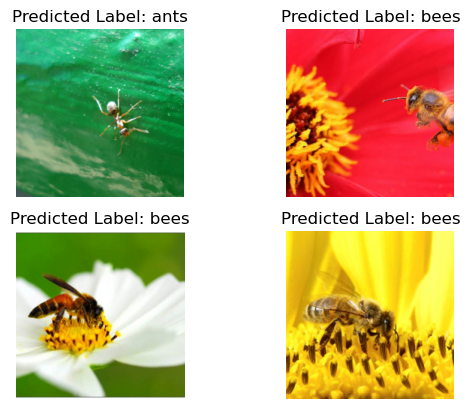

In [14]:
# Visualize some predictions
import matplotlib.pyplot as plt

fig = plt.figure()
shown_batch = 0
index = 0
with torch.no_grad():
    for (images, labels) in dataloaders['val']:
        if shown_batch == 1:
            break
        shown_batch+=1
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model_conv(images)
        _,preds=torch.max(outputs,1)

        for i in range(4):
            index +=1
            ax=plt.subplot(2,2,index)
            ax.axis('off')                                                    # get tensor of the image, anp put it to cpu
            ax.set_title('Predicted Label: {}'.format(class_names[preds[i]])) # if we have tensor of shape (2,3,4) --> it becomes (3,4,2)
            input_img = images.cpu().data[i]
            inp= input_img.numpy().transpose((1,2,0))
            mean = np.array([0.485,0.456,0.406])
            std = np.array([0.229,0.224,0.225])
            inp = std* inp +mean
            inp = np.clip(inp,0,1)
            plt.imshow(inp)